# Transformer로 번역기 만들기

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

# 10-2. 내부 모듈 구현하기

이번 코스는 트랜스포머를 완성하는 데에 필요한 모듈들을 하나하나 만든 후, 조립하여 완성하는 방식으로 진행할 겁니다.

자, Tensor로 변환한 입력 데이터가 주어졌다고 가정하고 흐름을 생각해 봅시다.   
최초의 텍스트 입력 데이터는 [ batch_size x length ] 의 형태를 가지고 있겠죠?   
번역이 끝나고 난 최종 출력 데이터는 [ batch_size x length x vocab_size ]의 형태를 가지게 됩니다. 번역 문제는 결국 매 스텝마다 vocab_size 만큼의 클래스 개수 중에 적당한 단어를 선택하는 작업을 length만큼 반복하는 것이니까요. 모델 구성하는 과정에서 레이어를 통과할 때마다 텐서의 shape가 어떻게 바뀌는지를 눈여겨봅시다.

1. 입력 데이터 → [ batch_size x length ]  
batch size = 문장갯수, length = 문장길이 = 단어갯수


2. Source & Target Embedding → [ batch_size x length x d_emb ]  

3. **Positional Encoding** 강의 노드에서 구현을 했었죠? 2번의 결과에 더해지므로 shape 변화는 없습니다.

4. **Multi-Head Attention** 아래와 같이 여러 개의 서브 모듈들이 존재합니다.  

    1. **Split Heads** →[ batch_size x length x heads x (d_emb / n_heads) ]  
    2. **Masking for Masked Attention**
    3. **Scaled Dot Product Attention**
    4. **Combine Heads** →[ batch_size x length x d_emb ]
5. Residual Connection
6. Layer Normalization
7. **Position-wise Feed-Forward Network** → [ batch_size x length x d_ff ]
8. Output Linear Layer → [ batch_size x length x vocab_size ]  

와... 정말 많네요... 그래도 굵게 표시된 모듈을 제외하면 나머지는 텐서플로우 내부에 이미 구현체가 포함되어 있어서 간단하게 사용할 수 있답니다! 게다가 차근차근 이해해나가면 하나도 어렵지 않은 내용들이에요. Positional Encoding부터 시작해보죠!

여느 때처럼 프로젝트에 사용될 라이브러리를 먼저 import 해주세요.

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import os
import io
import time
import random

import seaborn # Attention 시각화를 위해 필요!


## Positional Encoding

In [3]:
def positional_encoding(pos, d_model):
    table = np.zeros((pos, d_model))
    for i in range(pos):
        for j in range(d_model):
            table[i][j] = i / (10000 ** (2*(j//2) / d_model))
    
    sinusoid_table = table
    
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

## Multi-Head Attention

Multi-Head Attention은 여러 개의 서브 모듈을 결합하여 완성됩니다. Embedding된 입력을 Head 수로 분할하는 split_heads(), 분할된 입력으로부터 Attention 값을 구하는 scaled_dot_product_attention(), 연산이 종료되고 분할된 Head를 다시 하나로 결합시켜주는 combine_heads() 까지 MultiHeadAttention 클래스를 정의하여 모두 포함시켜줄 거예요!

뭔가 빠진 것 같다면 그것은 바로 Masking 부분! 마스크의 형태를 결정하는 것이 모델 외부의 훈련 데이터이기 때문에 그를 생성하는 함수는 MultiHeadAttention 외부에 정의되는 것이 올바르겠죠! 마스크를 생성하는 함수는 모델을 완성한 후에 구현하도록 하겠습니다. 대신 생성된 마스크를 처리할 수 있도록 scaled_dot_product_attention() 에는 아래 한 줄을 포함하세요!

#### scaled_qk: Attention을 위한 Softmax 직전의 Scaled QK
if mask is not None: scaled_qk += (mask * -1e9)

In [4]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        # scaled 할 때 필요해서 구해놓음
        # K shape : (문장갯수,문장길이,q,k,v의 차원)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
    				        
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

## Position-wise Feed Forward Network

d_ff 는 논문의 설명대로라면 2048 일 거고, d_model 은 512 겠죠? [ batch x length x d_model ] 의 입력을 받아 w_1 이 2048차원으로 매핑하고 활성함수 ReLU를 적용한 후, 다시 w_2 를 통해 512차원으로 되돌리는 과정까지! 이렇게 쉽게 FFN 완성입니다!

In [5]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)  # x 텐서를 w_1 layer에 넣고,
        out = self.w_2(out) # w_1텐서에서 나온 값을 w_2 layer에 넣어라
            
        return out

# 10-3. 모듈 조립하기

여기까지 내부에 포함될 모듈들을 모두 완성하셨습니다, 대단해요! 이 모든 모듈들을 가지고 트랜스포머를 완성할 수 있는데, 정확하게는 트랜스포머의 Encoder 한 층과 Decoder 한 층을 각각 완성할 수 있습니다!

그럼 이만큼의 코드를 5번 더 짜야 여섯 층짜리 논문 속 트랜스포머가 완성되나요..?

이런 걱정을 하셨다면 안심하세요, 우리는 조금 더 멋지고 효율적인 방법으로 트랜스포머를 완성할 거니까요!

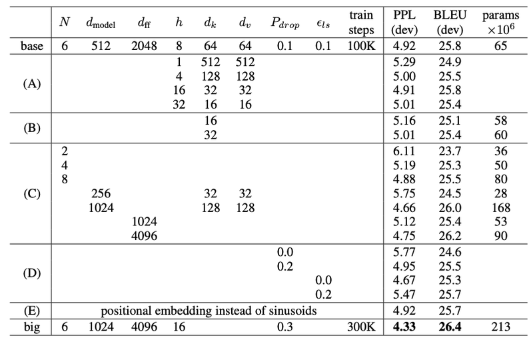

강의 노드가 아닌데 갑자기 표? 뜬금없지만 <Attention Is All You Need> 논문에 포함된 이 표는 트랜스포머가 얼마나 많은 실험을 통해서 탄생한 모델인지 보여줍니다. 이런 실험이 가능하게 하려면 모델이 동적으로 완성될 수 있게끔 해야 해요. 즉, 레이어 수를 원하는 만큼 쌓아 실험을 자유자재로 할 수 있게 모델을 완성하자는 거죠!

방법은 단순합니다, 마치 텐서플로우의 Dense 레이어를 사용하듯이 EncoderLayer, DecoderLayer를 쓸 수 있게 tf.keras.layers.Layer 클래스를 상속받아 레이어 클래스로 정의해 주면 돼요. 여러분은 이미 Layer 클래스를 정의해 본 적이 있는데, 바로 직전의 MultiHeadAttention 이 그렇게 정의된 레이어랍니다! 이 방법을 사용하면 아래와 같은 용법으로 트랜스포머 레이어를 사용할 수 있죠.

In [6]:
# N = 10

# # 10개의 Linear Layer를 한 방에!
# linear_layers = [tf.keras.layers.Dense(30) for _ in range(N)]

# # 10개의 Encoder Layer도 한 방에!
# enc_layers = [TransformerEncoderLayer(30) for _ in range(N)]

## Encoder 레이어 구현하기

실제 논문에서는 [Input] - [Module] - [Residual] - [Norm] (Module = MHA, FFN)으로 표현되어 있지만 정작 Official 구현인 구글의 Tensor2Tensor 에서는 [Input] - [Norm] - [Module] - [Residual] 방식을 사용했어요.
필자의 경험에 따르면 레이어가 많아질수록 후자가 약간 더 좋은 성능을 보였기에 필자는 논문 대신 Official 구현을 따르길 권장합니다! 

In [7]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x) # official 구현대로 norm 하고
        out, enc_attn = self.enc_self_attn(out, out, out, mask) # attn 하고
        out = self.dropout(out) # dropout 하고
        out += residual # 잔차 add
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out) # norm
        out = self.ffn(out) # FFN
        out = self.dropout(out) # dropout
        out += residual # 잔차 add
        
        return out, enc_attn

In [8]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

print("슝=3")

슝=3


## Decoder 레이어 구현하기
(참고: Decoder에서는 두 번의 Attention이 진행되니 반환되는 Attention도 두 개겠죠?)

In [9]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [10]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask): 
    # encoder와 달리 mask 종류가 두 개 나왔음
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

print("슝=3")

슝=3


# Transformer 완성하기
정의된 Encoder 와 Decoder 를 가지고 최종적으로 트랜스포머를 완성합니다!

아래 조건을 만족하며 소스의 빈칸을 채워 Transformer 클래스를 완성하세요!

shared 변수를 매개변수로 받아 True 일 경우 Decoder Embedding과 출력층 Linear의 Weight를 공유 할 수 있게 하세요! Weight가 공유될 경우 Embedding 값에 sqrt(d_model) 을 곱해줘야 하는 것, 잊지 않으셨죠? (참고: tf.keras.layers.Layer.set_weights())

우리가 정의한 positional_encoding 의 반환값 형태는 [ Length x d_model ] 인데, 이를 더해 줄 Embedding 값 형태가 [ Batch x Length x d_model ] 이라서 연산이 불가능합니다. 연산이 가능하도록 수정하세요! (참고: tf.expand_dims(), np.newaxis)

In [11]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        
        """
        1. Embedding Layer 정의
        2. Positional Encoding 정의
        3. Encoder / Decoder 정의
        4. Output Linear 정의
        5. Shared Weights
        6. Dropout 정의
        """
        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model) 
        # (몇번위치에서의,임베딩차원)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        """
        입력된 정수 배열을 Embedding + Pos Encoding
        + Shared일 경우 Scaling 작업 포함

        x: [ batch x length ]
        return: [ batch x length x d_model ]
        """
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        """
        Step 1: Embedding(enc_in, dec_in) -> enc_in, dec_in
        Step 2: Encoder(enc_in, enc_mask) -> enc_out, enc_attns
        Step 3: Decoder(dec_in, enc_out, mask)
                -> dec_out, dec_attns, dec_enc_attns
        Step 4: Out Linear(dec_out) -> logits
        """
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

# 10-4. 모델 밖의 조력자들
아까부터 은근하게 마음 한구석을 차지하고 있던 Masking을 살펴볼 시간이 다가왔습니다. 그리고 트랜스포머의 Learning Rate가 일반적이지 않다는 것도 기억하고 계실 거예요! 지금부터는 모델 외적인 부분을 정의해 주도록 하겠습니다. 이번 스텝에서는 데이터의 특성이나 학습 과정에 따라 달라지는 부분을 다루게 됩니다.

먼저 Masking입니다. 이전 노드에서 배운 generate_causality_mask() 를 그대로 사용하면 되는데, 약간 추가할 내용이 있습니다! 아래 구현을 먼저 보실까요?

# Masking

In [12]:
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

generate_padding_mask() 는 Attention을 할 때에 <PAD> 토큰에도 Attention을 주는 것을 방지해 주는 역할을 합니다. 일전에 Sequence-to-Sequence 모델에서 Loss에 대한 Masking을 해줄 때도 위와 같은 방법으로 진행했죠? 한 배치의 데이터에서 <PAD> 토큰으로 이뤄진 부분을 모두 찾아내는 마스크를 생성합니다. 눈으로 직접 확인해보죠!

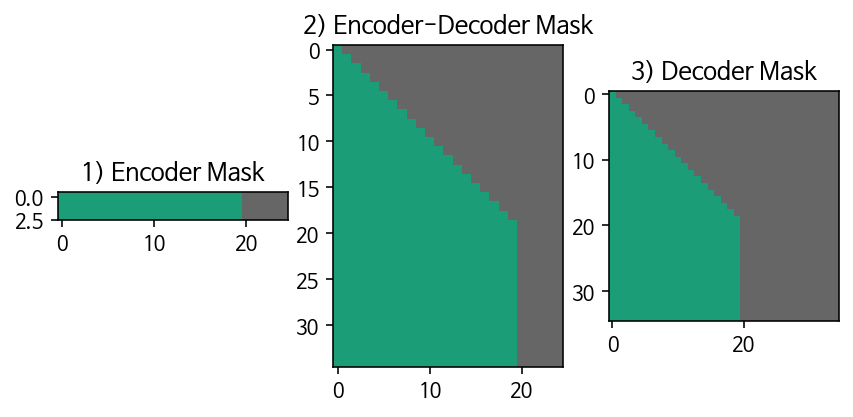

In [13]:
import matplotlib.pyplot as plt

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

첫 번째 마스크는 각 배치 별로 데이터의 꼬리 부분을 Masking 하는 형태임을 알 수 있습니다. 낯선 부분은 두 번째와 세 번째의 Decoder가 연관된 마스크인데... 이것이 바로 Causality Mask와 Padding Mask를 결합한 형태입니다! 자기 회귀적인 특성을 살리기 위해 Masked Multi-Head Attention에서 인과 관계 마스킹을 했던 것을 기억하시죠? 인과 관계를 가리는 것도 중요하지만 Decoder 역시 <PAD> 토큰은 피해 가야 하기 때문에 이런 형태의 마스크가 사용된답니다!

또, 트랜스포머는 고정된 Learning Rate를 사용하지 않았었죠! 논문의 해당 부분을 Optimizer까지 포함하여 다시 한번 살펴봅시다. 이전 노드에서 Learning Rate를 numpy 로 간단히 구현을 했었는데, 이번엔 Tensorflow 상에서 잘 구동될 수 있도록 LearningRateSchedule 클래스를 상속받아 구현해보죠!

# Learning Rate

In [14]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

트랜스포머가 제안한 수식이 아니더라도 가변적인 Learning Rate를 사용하려면 위와 같이 구현을 하시면 됩니다. Optimizer와 Scheduler를 연결하는 과정도 아주 간단하죠! Optimizer는 논문에 정의된 대로 Adam Optimizer를 사용하며 세부 파라미터도 동일하게 맞춰 줍니다.

# 10-5. 프로젝트: 더 멋진 번역기 만들기

In [15]:
import tensorflow
import numpy
import matplotlib

# Step 1. 데이터 다운로드

In [16]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    unique_pairs = set(zip(kor, eng))
    cleaned_corpus = zip(*unique_pairs)
    cleaned_corpus = list(cleaned_corpus)
    print(len(unique_pairs))
    
    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)

print(len(cleaned_corpus))

78968
2


In [17]:
type(cleaned_corpus)

list

In [18]:
cleaned_corpus[0]

('한 투자자가 판사에게 그녀는 버나드 메이도프의 오늘 유죄 인정을 수용할 수 없다고 말하며, 투자금을 찾을 때까지 그의 유죄 인정에 반대한다고 했습니다.',
 '30대의 차량이 파괴되었으며, 50명의 아프리카 연합군이 행방 불명되고, 7명은 중상을 입었다.',
 '원문기사보기 올해 1월 카스피 해에 줄무늬 모양으로 나열된 구름 기둥부터 12월 볼리비아dml 청정 숲의 대규모 지대까지 미 항공우주국(NASA) 지구천문대가 놀랄 만큼 아름다운 지구 모습들을 포착했다.',
 '한편 18명의 의회의원과 지역 고위인사들이 설탕공장을 방문할 당시 학생들이 인근 도로에서 이들을 맞이해 아이들의 피해도 컸다.',
 '현지 경찰은 화재가 새벽 시간에 발생했으며 40명의 소방대원들이 몇 시간 동안 진화작업을 펴 불을 끌 수 있었다고 설명했다.',
 '“우리는 이전에 강했던 것이라고 보고, 그들을 세 번 이기는 데에 초점을 두지 않고 아직 치르지 않은 한 경기에만 집중할 것입니다.',
 '경찰은 요원 중 아무도 그에게 총격을 가하지 않았기때문에 그가 스스로 목숨을 끊으려 한 것으로 추정하고 있다.',
 '이 최신 디스플레이는 두 가지 기술이 접목된다.',
 '또 지나치게 햇빛을 받게 되면 피부암에 걸린 위험성도 증가한다.',
 '도합 9,140만주를 주당 11,900원에 매입한다고 SKT가 성명에서 밝혔다.',
 '교황은 피해자 5~6명과 개별적으로 몇 분간 만났으며 이들 중 일부는 교황 알현 도중 눈물을 흘리기도 했다.',
 '연구진은 슬픔도 사회 공동체에서 퍼지지만 전파속도가 그리 빠르지 않다고 밝혔다.',
 '버팔로 나이아가라 국제공항도 대다수 비행기 운항이 취소했다.',
 '미국과 이란은 27년 전 외교관계를 단절했으며 지난 5월 28일 외교관계 단절 이후 처음으로 양국 고위 관계자가 회담을 재개했다.',
 '케냐 대선에서는 음와이 키바키 현 대통령과 야당 지도자인 오렌지민주운동(ODM)의 라일라 오딩가 의원이 접전을 벌이고 있다.',
 '미국 민주당의 대선후보인 버락 

In [19]:
cleaned_corpus[1]

('At least two other investors have said the same thing, but apparently the judge has accepted his plea:',
 'Thirty vehicles overran the base, and 50 AU soldiers were missing and seven seriously injured.',
 'From columns of cloud streaking over the Caspian Sea in January to vast tracts of cleared forest in Bolivia in December. In 2008, the NASA Earth Observatory has captured more stunning images of the Earth.',
 'School children had lined the route where up to 18 national lawmakers and dozens more local dignitaries walked on their way to the factory when the blast went off, prompting local officials to believe that children may be among the dead and wounded.',
 'Police say the blaze, which began before dawn and took 40 firefighters several hours to extinguish, is being treated as "suspicious."',
 "“We'll be the onetime this tough so we're not going to be focused on beating them three times, we're just going to be focused on the one game we haven't had.",
 'Police assume he tried to tak

# Step 2. 데이터 정제 & 토큰화

### 정제
정제 함수를 아래 조건을 만족하게 정의하세요.
- 모든 입력을 소문자로 변환합니다.
- 알파벳, 문장부호, 한글만 남기고 모두 제거합니다.
- 문장부호 양옆에 공백을 추가합니다.
- 문장 앞뒤의 불필요한 공백을 제거합니다.

In [20]:
import re
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^가-힣a-zA-Z?.!, ]+", "", sentence)
    sentence = sentence.strip()
    
    return sentence

In [21]:
preprocess_sentence('도레미Dore-mi?!')

'도레미doremi ? !'

In [22]:
ko_sentences = cleaned_corpus[0]
type(ko_sentences)

tuple

In [23]:
# 전처리된 문장을 저장할 리스트
ko_preprocessed_sentences = []

# 튜플의 각 문장을 전처리하여 preprocessed_sentences 리스트에 저장
for sentence in ko_sentences:
    preprocessed_sentence = preprocess_sentence(sentence)
    ko_preprocessed_sentences.append(preprocessed_sentence)
    
# 전처리된 문장을 출력
print(ko_preprocessed_sentences[0])
print(type(ko_preprocessed_sentences))

한 투자자가 판사에게 그녀는 버나드 메이도프의 오늘 유죄 인정을 수용할 수 없다고 말하며 , 투자금을 찾을 때까지 그의 유죄 인정에 반대한다고 했습니다 .
<class 'list'>


In [24]:
# 리스트를 텍스트 파일로 저장
with open('ko_preprocessed_sentences.txt', 'w') as f:
    for item in ko_preprocessed_sentences:
        f.write("%s\n" % item)

In [25]:
# 영어도 전처리하고 txt로 저장하기
en_sentences = cleaned_corpus[1]
en_preprocessed_sentences = []
for sentence in en_sentences:
    preprocessed_sentence = preprocess_sentence(sentence)
    en_preprocessed_sentences.append(preprocessed_sentence)

print(en_preprocessed_sentences[0])
print(type(en_preprocessed_sentences))

at least two other investors have said the same thing , but apparently the judge has accepted his plea
<class 'list'>


In [26]:
with open('en_preprocessed_sentences.txt', 'w') as f:
    for item in en_preprocessed_sentences:
        f.write("%s\n" % item)

### 토큰화
한글 말뭉치 kor_corpus 와 영문 말뭉치 eng_corpus 를 각각 분리한 후, 정제하여 토큰화를 진행합니다! 토큰화에는 Sentencepiece를 활용하세요. 첨부된 공식 사이트를 참고해 아래 조건을 만족하는 generate_tokenizer() 함수를 정의합니다. 최종적으로 ko_tokenizer 과 en_tokenizer 를 얻으세요. en_tokenizer에는 set_encode_extra_options("bos:eos") 함수를 실행해 타겟 입력이 문장의 시작 토큰과 끝 토큰을 포함할 수 있게 합니다.

- 단어 사전을 매개변수로 받아 원하는 크기의 사전을 정의할 수 있게 합니다. (기본: 20,000)
- 학습 후 저장된 model 파일을 SentencePieceProcessor() 클래스에 Load()한 후 반환합니다.
- 특수 토큰의 인덱스를 아래와 동일하게 지정합니다.
    - \<PAD> : 0 / \<BOS> : 1 / \<EOS> : 2 / \<UNK> : 3
    
    
참조사이트 : https://donghwa-kim.github.io/SPM.html

In [27]:
# Kor
import sentencepiece as spm
templates= '--input={} \
--pad_id={} \
--bos_id={} \
--eos_id={} \
--unk_id={} \
--model_prefix={} \
--vocab_size={} \
--character_coverage={} \
--model_type={}'


train_input_file = "ko_preprocessed_sentences.txt"
pad_id=0  #<pad> token을 0으로 설정
vocab_size = 20000 # vocab 사이즈
prefix = 'kor_spm' # 저장될 tokenizer 모델에 붙는 이름
bos_id=1 #<start> token을 1으로 설정
eos_id=2 #<end> token을 2으로 설정
unk_id=3 #<unknown> token을 3으로 설정
character_coverage = 1.0 # to reduce character set 
model_type ='word' # Choose from unigram (default), bpe, char, or word


cmd = templates.format(train_input_file,
                pad_id,
                bos_id,
                eos_id,
                unk_id,
                prefix,
                vocab_size,
                character_coverage,
                model_type)

spm.SentencePieceTrainer.Train(cmd)   
ko_tokenizer = spm.SentencePieceProcessor()
ko_tokenizer.Load('kor_spm.model') # prefix이름으로 저장된 모델
ko_tokenizer.SetEncodeExtraOptions('bos:eos')

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=ko_preprocessed_sentences.txt --pad_id=0 --bos_id=1 --eos_id=2 --unk_id=3 --model_prefix=kor_spm --vocab_size=20000 --character_coverage=1.0 --model_type=word
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ko_preprocessed_sentences.txt
  input_format: 
  model_prefix: kor_spm
  model_type: WORD
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_i

True


  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
}
normalizer_spec {
  name: nmt_nfkc
  add_dummy_prefix: 1
  remove_extra_whitespaces: 1
  escape_whitespaces: 1
  normalization_rule_tsv: 
}
denormalizer_spec {}
trainer_interface.cc(329) LOG(INFO) SentenceIterator is not specified. Using MultiFileSentenceIterator.
trainer_interface.cc(178) LOG(INFO) Loading corpus: ko_preprocessed_sentences.txt
trainer_interface.cc(385) LOG(INFO) Loaded all 78967 sentences
trainer_interface.cc(400) LOG(INFO) Adding meta_piece: <pad>
trainer_interface.cc(400) LOG(INFO) Adding meta_piece: <s>
trainer_interface.cc(400) LOG(INFO) Adding meta_piece: </s>
trainer_interface.cc(400) LOG(INFO) Adding meta_piece: <unk>
trainer_interface.cc(405) LOG(INFO) Normalizing sentences...
trainer_interface.cc(466) LOG(INFO) all chars count=5019361
trainer_interface.cc(487) LOG(INFO) Alphabet size=1669
trainer_interface.cc(488) LOG(INFO) Final character coverage=1
trainer_interfa

In [28]:
# Eng
import sentencepiece as spm
templates= '--input={} \
--pad_id={} \
--bos_id={} \
--eos_id={} \
--unk_id={} \
--model_prefix={} \
--vocab_size={} \
--character_coverage={} \
--model_type={}'


train_input_file = "en_preprocessed_sentences.txt"
pad_id=0  #<pad> token을 0으로 설정
vocab_size = 20000 # vocab 사이즈
prefix = 'eng_spm' # 저장될 tokenizer 모델에 붙는 이름
bos_id=1 #<start> token을 1으로 설정
eos_id=2 #<end> token을 2으로 설정
unk_id=3 #<unknown> token을 3으로 설정
character_coverage = 1.0 # to reduce character set 
model_type ='word' # Choose from unigram (default), bpe, char, or word


cmd = templates.format(train_input_file,
                pad_id,
                bos_id,
                eos_id,
                unk_id,
                prefix,
                vocab_size,
                character_coverage,
                model_type)

spm.SentencePieceTrainer.Train(cmd)   
en_tokenizer = spm.SentencePieceProcessor()
en_tokenizer.Load('eng_spm.model') # prefix이름으로 저장된 모델
en_tokenizer.SetEncodeExtraOptions('bos:eos')

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=en_preprocessed_sentences.txt --pad_id=0 --bos_id=1 --eos_id=2 --unk_id=3 --model_prefix=eng_spm --vocab_size=20000 --character_coverage=1.0 --model_type=word
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: en_preprocessed_sentences.txt
  input_format: 
  model_prefix: eng_spm
  model_type: WORD
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_i

True

In [29]:
print(ko_tokenizer.GetPieceSize())
print(en_tokenizer.GetPieceSize())

20000
20000


In [30]:
ko_tokenizer.EncodeAsPieces('나는 오늘 밥을 먹었다')

['<s>', '▁나는', '▁오늘', '▁밥을', '▁먹었다', '</s>']

In [31]:
en_tokenizer.EncodeAsPieces('I love you')

['<s>', '▁I', '▁love', '▁you', '</s>']

## 길이 50 이하인 문장만 사용하기
토크나이저를 활용해 토큰의 길이가 50 이하인 데이터를 선별하여 src_corpus 와 tgt_corpus 를 각각 구축하고, 텐서 enc_train 과 dec_train 으로 변환하세요! (❗모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸립니다.)

In [32]:
print(ko_preprocessed_sentences[0])
print(len(ko_preprocessed_sentences))
print(len(ko_preprocessed_sentences[0]))
print(en_preprocessed_sentences[0])
print(len(en_preprocessed_sentences))
print(len(en_preprocessed_sentences[0]))

한 투자자가 판사에게 그녀는 버나드 메이도프의 오늘 유죄 인정을 수용할 수 없다고 말하며 , 투자금을 찾을 때까지 그의 유죄 인정에 반대한다고 했습니다 .
78968
86
at least two other investors have said the same thing , but apparently the judge has accepted his plea
78968
102


In [33]:
from tqdm import tqdm
src_corpus = []
tgt_corpus = []
sequence_len = 50 #토큰 길이

kor_corpus = ko_preprocessed_sentences
eng_corpus = en_preprocessed_sentences

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 미만 문장만  
for idx in tqdm(range(len(kor_corpus))):
    if (len(ko_tokenizer.EncodeAsIds(kor_corpus[idx])) < sequence_len) & (len(en_tokenizer.EncodeAsIds(eng_corpus[idx])) < sequence_len): 
        src_corpus.append(ko_tokenizer.encode_as_ids(kor_corpus[idx]))
        tgt_corpus.append(en_tokenizer.encode_as_ids(eng_corpus[idx]))
        
# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_tensor = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_tensor = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

100%|██████████| 78968/78968 [00:06<00:00, 12862.22it/s]


In [34]:
# 데이터셋 정리하기 (val 뺴두기)

from sklearn.model_selection import train_test_split
enc_train, enc_val, dec_train, dec_val = \
train_test_split(enc_tensor, dec_tensor, test_size=0.2)

In [35]:
print(enc_train.shape, enc_val.shape, dec_train.shape, dec_val.shape)
print(enc_train[0])
print(dec_train[0])

(61647, 49) (15412, 49) (61647, 49) (15412, 49)
[   1 4599    2    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0]
[    1     7  1367    80  3609     7    41  3492 15592    47    36  1388
    50   874   227   179  1075    79    16  4429     8   452   341  2479
     4  1196   121    37  1684    13    19   176   260   210     5     2
     0     0     0     0     0     0     0     0     0     0     0     0
     0]


# Step 3. 모델 설계

# Loss
Loss 함수를 정의하세요.
Sequence-to-sequence 모델에서 사용했던 Loss와 유사하되, Masking 되지 않은 입력의 개수로 Scaling하는 과정을 추가합니다. (트랜스포머가 모든 입력에 대한 Loss를 한 번에 구하기 때문입니다.)

In [36]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

# train_step 함수
입력 데이터에 알맞은 Mask를 생성하고, 이를 모델에 전달하여 연산에서 사용할 수 있게 합니다.

In [37]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

# Eval Step 함수 정의

@tf.function()
def eval_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    predictions, enc_attns, dec_attns, dec_enc_attns = \
    model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
    loss = loss_function(gold, predictions[:, :-1])
    
    return loss, enc_attns, dec_attns, dec_enc_attns

# 학습

In [38]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [39]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [40]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [41]:
ss

NameError: name 'ss' is not defined

In [ ]:
n_layers = 2
d_model = 512 
n_heads = 8 
d_ff = 2048
src_vocab_size = 20000
tgt_vocab_size = 20000
pos_len = sequence_len # 50
dropout = 0.2
BATCH_SIZE = 64


transformer = Transformer(
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout
                    )

In [ ]:
from tqdm import tqdm
import random


EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
        
    test_loss = 0
    
    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    
    
    for (test_batch, idx) in enumerate(t):
        test_batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        eval_step(enc_val[idx:idx+BATCH_SIZE],
                    dec_val[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        test_loss += test_batch_loss
        
        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

        


In [ ]:
examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

In [ ]:
for example in examples:
    translate(example, transformer, ko_tokenizer, en_tokenizer)

## Learning Rate, Optimizer
논문에서 사용한 것과 동일한 Learning Rate Scheduler를 선언하고, 이를 포함하는 Adam Optimizer를 선언하세요. (Optimizer의 파라미터 역시 논문과 동일하게 설정합니다.)

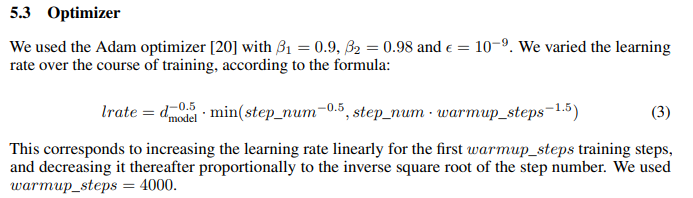

In [42]:
n_layers = 2
d_model = 512 
n_heads = 8 
d_ff = 2048
src_vocab_size = 20000
tgt_vocab_size = 20000
pos_len = sequence_len # 50
dropout = 0.2
BATCH_SIZE = 64


transformer = Transformer(
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout
                    )

In [43]:
learning_rate = LearningRateScheduler(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

In [44]:
from tqdm import tqdm
import random


EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
        
    test_loss = 0
    
    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    
    
    for (test_batch, idx) in enumerate(t):
        test_batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        eval_step(enc_val[idx:idx+BATCH_SIZE],
                    dec_val[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        test_loss += test_batch_loss
        
        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

        


Test Epoch 10: 100%|██████████| 241/241 [00:16<00:00, 14.43it/s, Test Loss 7.2087]


In [45]:
examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

In [46]:
for example in examples:
    translate(example, transformer, ko_tokenizer, en_tokenizer)

Input: 오바마는 대통령이다.
Predicted translation: obama also ⁇  the frontrunner for his nomination .
Input: 시민들은 도시 속에 산다.
Predicted translation:  ⁇  peace is ⁇  in the urban area .
Input: 커피는 필요 없다.
Predicted translation: you dont need to care .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the seven left seven dead .


# 회고

seq2seq보다 빠르고 잘나오는 것 같아서 좋긴한데,,

각각의 모듈이해는 얼추 한 것 같으나,
이외의 learning rate, warmup steps 등 세부적인 하이퍼파라미터 설정하는 법과
train으로 넘어가는 부분의 이해가 덜 된 듯 하다.
다시 주의해서 복습할것.
---
논문에 나온대로 lr 과 optimizer를 넣었으나
결과는 별 차이가 없는듯하다. 
다른 하이퍼파라미터를 만져봐야 될 듯.

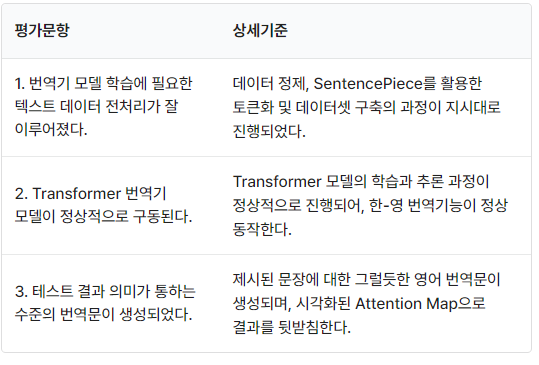